# Hazard assessment for drought-exposed population

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/CLIMAAX/DROUGHTS/main?labpath=03_population_exposed_to_drought/Hazard_assessment_DROUGHT_POP.ipynb) [![Droughts](https://img.shields.io/badge/DROUGHTS_GitHub-repository-blue)](https://github.com/CLIMAAX/DROUGHTS/tree/main)

## Hazard assessment methodology

In this workflow, we will assess the drought hazard data, expressed as Combined Drought Indicator (CDI).

```{admonition} Hazard data
**The Combined Drought Indicator (CDI)** that is implemented in the European Drought Observatory (EDO) is used to identify areas affected by agricultural drought, and areas with the potential to be affected. CDI can be downloaded from the [Copernicus data server](https://edo.jrc.ec.europa.eu/gdo/php/index.php?id=2112) and is derived by combining three drought indicators produced operationally in the EDO framework - namely the 
- **Standardized Precipitation Index (SPI)**,
- **the Soil Moisture Anomaly (SMA)**, and
- **the FAPAR Anomaly** - in such a way that areas are classified according to three primary drought classes:
  1. “Watch” - indicating that precipitation is less than normal;
  2. “Warning” - indicating that soil moisture is in deficit; and
  3. “Alert” - indicating that vegetation shows signs of stress.  
  ##### Two additional classes - namely
  4. “Partial recovery” and
  5. “Recovery” - identify the stages of the vegetation recovery process. 
```

:::{list-table} Classification scheme
:widths: 15 10 40
:header-rows: 1

*   - LEVEL
    - COLOUR
    - CLASIFICATION CONDITION
*   - Watch
    - yellow
    - SPI-3 <-1 or SPI-1 < -2
*   - Warning
    - orange
    - SMA <-1 and (SPI-3 < -1 or SPI-1 < -2)
*   - Alert
    - red
    - {math}`\Delta`FAPAR < -1 and (SPI-3 < -1 or SPI-1 < -2)
*   - Partial recovery
    - brown
    - ({math}`\Delta`FAPAR < -1 and (SPI-3{sub}`m-1` < -1 or SPI-3 > -1) or\
      ({math}`\Delta`FAPAR < -1 and (SPI-1{sub}`m-1` < -2 or SPI-1 > -2)
*   - Full recovery
    - grey
    - (SPI-3{sub}`m-1` < -1 and SPI-3 > -1) or\
      (SPI-1{sub}`m-1` < -2 or SPI-1 > -2)
:::

## Preparation work

### Load libraries

:::{admonition} Find more info about the libraries used in this workflow here
:class: hint dropdown
In this notebook we will use the following Python libraries:
- [os](https://docs.python.org/3/library/os.html) - To create directories and work with files
- [pooch](https://www.fatiando.org/pooch/latest/index.html) - To download and unzip the data
- [rasterio](https://rasterio.readthedocs.io/en/stable/) - To access and explore geospatial raster data in GeoTIFF format
- [xarray](https://docs.xarray.dev/en/stable/) - To process the data and prepare it for damage calculation
- [rioxarray](https://corteva.github.io/rioxarray/stable/) - Rasterio xarray extension - to make it easier to use GeoTIFF data with xarray
- [cartopy](https://scitools.org.uk/cartopy/docs/latest/) - To plot the maps
- [matplotlib](https://matplotlib.org/) - For plotting as well
:::

In [1]:
import os
import pooch

import numpy as np
import rasterio
from pathlib import Path
import rioxarray as rxr
import xarray as xr

import pyproj

import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

### Create the directory structure

In order for this workflow to work even if you download and use just this notebook, we need to set up the directory structure for the in- and output data.

Create a directory called `drought_workflow` in the same directory where this notebook is saved:

In [2]:
workflow_folder = 'simple_drought_workflow'
if not os.path.exists(workflow_folder):
    os.makedirs(workflow_folder)

Create a `data` directory inside the `drought_workflow` folder:

In [3]:
data_dir = os.path.join(workflow_folder,'data')
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

## Download data

In this workflow we will use a mix of data that is available to download from the notebook, but can also be downloaded using the Copernicus Drought Observatory website.

Since there is no API to download this data, to programatically download the data we can use **[pooch](https://www.fatiando.org/pooch/latest/index.html)** library. Pooch can also unzip the data.  

Pooch will check if the zip file already exists by comparing the hash of the file with what is stored in the default and only download it if it is not already there.

### The Combined Drought Indicator (CDI)

This dataset must be manually downloaded from the [Copernicus Drought Observatory data server](https://edo.jrc.ec.europa.eu/gdo/php/index.php?id=2112).

To download the data, you can select all years and click **Download**. Save the data in the **data_dir** folder.

We will only use data from 2022, but data is available for the period 2012-2024. The dataset is available in GeoTIFF and netCDF formats. Here, we choose netCDF and download the file with pooch:

In [4]:
url = 'https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/DROUGHTOBS/Drought_Observatories_datasets/EDO_Combined_Drought_Indicator/ver3-0-1/cdinx_m_euu_20220101_20221221_t.nc'
filename = 'cdinx_m_euu_20220101_20221221_t.nc'
known_hash = '7a40b16e5a0cfd53a22ef092f6a8bb511925972c9aaa9913a563c7e8585492e7'

pooch.retrieve(url=url, known_hash=known_hash, path=data_dir, fname=filename)

We can list all files in the `data_dir` directory using the os library.

In [5]:
with os.scandir(data_dir) as entries:
    for entry in entries:
        print(entry.name)

cdinx_m_euu_20220101_20221221_t.nc


## Explore the data

Now that we have fetched the required data, we can have a look at what is inside.

### The Combined Drought Indicator (CDI)

All downloaded netCDF files are stored in our `data_dir`, with file names starting with `cdinx_m_euu_`, followed by the start and end date period, and ending with `_t.nc`.

First, we can explore one of them:

In [6]:
cdi_nc = xr.open_dataset(f"{data_dir}/cdinx_m_euu_20220101_20221221_t.nc")
cdi_nc

<xarray.Dataset> Size: 137MB
Dimensions:  (time: 36, lat: 950, lon: 1000)
Coordinates:
  * lat      (lat) int64 8kB 5497500 5492500 5487500 ... 762500 757500 752500
  * lon      (lon) int64 8kB 2502500 2507500 2512500 ... 7487500 7492500 7497500
  * time     (time) datetime64[ns] 288B 2022-01-01 2022-01-11 ... 2022-12-21
Data variables:
    cdinx    (time, lat, lon) float32 137MB ...
    3035     float32 4B ...
Attributes: (12/27)
    Source_Software:            dbinterface.py, dbexport.py, netcdf_handling.py
    creator_name:               Carolina Arias Munoz
    Conventions:                CF-1.6
    _CoordSysBuilder:           ucar.nc2.dataset.conv.CF1Convention
    date_created:               2023-06-23
    01.title:                   Combined Drought Indicator (CDI), v.3.0.1
    ...                         ...
    17.factsheet_url:           https://edo.jrc.ec.europa.eu/documents/factsh...
    18.jrc_data_catalogue_url:  https://data.jrc.ec.europa.eu/dataset/afa8a5e...
    19.sample_url:              /images/map_examples/dbio_data_previews/cdinx...
    20.metadata_last_updated:   2023-04-05
    21.values_legend:           0: No drought, 1: Watch. Precipitation defici...
    22.version_notes:           Current version: Version 3.0.1 covers data fr...

There are 36 time stamps for 12 months in the year 2022. This is because this index is calculated from satellite data that take 10 days to collect the information for the whole globe. The index of each time step corresponds to the start date of the associated 10-day time interval.

:::{tip} Explore the file content

Feel free to explore the content and structure of the datasets. Note the coordinates, dimensions and attributes!
:::

:::{hint} Information about spatial references, statistics
:class: dropdown

👋 Click on 📄 _show/hide attributes_ of the **3035** data variable to see information about its projection.  
👋 Click on _Attributes_ to expand further metadata including projection, resolution, extent, links to documentation, data catalogue etc.
:::

## Process the data

To check which times are available, you can inspect the data cells above, or print the time series like in the next cell:

In [7]:
cdi_nc.time

<xarray.DataArray 'time' (time: 36)> Size: 288B
array(['2022-01-01T00:00:00.000000000', '2022-01-11T00:00:00.000000000',
       '2022-01-21T00:00:00.000000000', '2022-02-01T00:00:00.000000000',
       '2022-02-11T00:00:00.000000000', '2022-02-21T00:00:00.000000000',
       '2022-03-01T00:00:00.000000000', '2022-03-11T00:00:00.000000000',
       '2022-03-21T00:00:00.000000000', '2022-04-01T00:00:00.000000000',
       '2022-04-11T00:00:00.000000000', '2022-04-21T00:00:00.000000000',
       '2022-05-01T00:00:00.000000000', '2022-05-11T00:00:00.000000000',
       '2022-05-21T00:00:00.000000000', '2022-06-01T00:00:00.000000000',
       '2022-06-11T00:00:00.000000000', '2022-06-21T00:00:00.000000000',
       '2022-07-01T00:00:00.000000000', '2022-07-11T00:00:00.000000000',
       '2022-07-21T00:00:00.000000000', '2022-08-01T00:00:00.000000000',
       '2022-08-11T00:00:00.000000000', '2022-08-21T00:00:00.000000000',
       '2022-09-01T00:00:00.000000000', '2022-09-11T00:00:00.000000000',
       '2022-09-21T00:00:00.000000000', '2022-10-01T00:00:00.000000000',
       '2022-10-11T00:00:00.000000000', '2022-10-21T00:00:00.000000000',
       '2022-11-01T00:00:00.000000000', '2022-11-11T00:00:00.000000000',
       '2022-11-21T00:00:00.000000000', '2022-12-01T00:00:00.000000000',
       '2022-12-11T00:00:00.000000000', '2022-12-21T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 288B 2022-01-01 2022-01-11 ... 2022-12-21
Attributes:
    standard_name:  time

For now we select just one time stamp for the CDI data. We can use the `.sel()` method of xarray to select one time step:

In [8]:
cdi = cdi_nc.sel(time='2022-08-01T00:00:00.000000000')

### Select the area of interest

We define the coordinates of the area of interest. Based on these coordinates we will be able to clip the dataset for further processing, and eventually display hazard and damage maps for the selected area.

To easily define an area in terms of geographical coordinates, you can use the [Bounding Box Tool](https://boundingbox.klokantech.com/) to select a region and get the corresponding coordinates. Make sure to select 'CSV' in the lower left corner and copy the values in the brackets into the cell below.

In this workflow example, we will concentrate on the area of Catalonia. It is found roughly between 0°E and 3.4°E longitude and 40.5°N and 42.9°N latitude:

In [9]:
xmin=0
ymin=40.5
xmax=3.4
ymax=42.9

However, the CDI dataset has its spatial coordinates in meters, so we first need to transform our coordinates to know where to clip to our selected area. For this we use the [pyproj](https://pyproj4.github.io/pyproj/stable/index.html) library. Here we use the [proj-string](https://proj.org/en/9.3/usage/quickstart.html) of the Lambert Azimuthal Equal Area (LAEA) projection. This information can be found in the attributes of the CDI datatset for the **3035** variable:

In [10]:
cdi_nc["3035"].proj4_params

'+proj=laea +lat_0=52 +lon_0=10 +x_0=4321000+y_0=3210000 +ellps=GRS80 +units=m +no_defs'

In [11]:
xyproj = pyproj.Proj('+proj=laea +lat_0=52 +lon_0=10 +x_0=4321000 +y_0=3210000 +ellps=GRS80 +units=m +no_defs')
latlonproj = pyproj.Proj('epsg:4326')
transformer = pyproj.Transformer.from_proj(latlonproj, xyproj)
(xmin_xyproj,ymin_xyproj) = transformer.transform(ymin, xmin)
(xmax_xyproj,ymax_xyproj) = transformer.transform(ymax, xmax)

Here are our transformed coordinates of the boundary box:

In [12]:
xmin_xyproj,ymin_xyproj

(3472008.40051275, 1989781.4970224823)

In [13]:
xmax_xyproj,ymax_xyproj

(3781134.3733767485, 2222944.719518429)

:::{caution}

One very sneaky thing to note here is that latitudes (y dimension) in the dataset are **decreasing**. This is very important as this means we need to have the minimum and maximum y value in this order when selecting the area.
:::

We can select our area in two ways: with the `.sel()` method of xarray or `.rio.clip_box()` provided by rasterio:

::::{tab-set}

:::{tab-item} xarray
```
catalonia_cdi = cdi.sel(lat=slice(ymax_xyproj,ymin_xyproj), 
                        lon=slice(xmin_xyproj,xmax_xyproj))
```
:::

:::{tab-item} rasterio
```
catalonia_cdi = cdi.rio.clip_box(
    minx=xmin,
    miny=ymin,
    maxx=xmax,
    maxy=ymax,
   crs="EPSG:3050",
)
```
:::

::::

Let's use xarray:

In [14]:
catalonia_cdi = cdi.sel(lat=slice(ymax_xyproj,ymin_xyproj), 
                        lon=slice(xmin_xyproj,xmax_xyproj))
catalonia_cdi

<xarray.Dataset> Size: 13kB
Dimensions:  (lat: 47, lon: 62)
Coordinates:
  * lat      (lat) int64 376B 2222500 2217500 2212500 ... 1997500 1992500
  * lon      (lon) int64 496B 3472500 3477500 3482500 ... 3772500 3777500
    time     datetime64[ns] 8B 2022-08-01
Data variables:
    cdinx    (lat, lon) float32 12kB ...
    3035     float32 4B ...
Attributes: (12/27)
    Source_Software:            dbinterface.py, dbexport.py, netcdf_handling.py
    creator_name:               Carolina Arias Munoz
    Conventions:                CF-1.6
    _CoordSysBuilder:           ucar.nc2.dataset.conv.CF1Convention
    date_created:               2023-06-23
    01.title:                   Combined Drought Indicator (CDI), v.3.0.1
    ...                         ...
    17.factsheet_url:           https://edo.jrc.ec.europa.eu/documents/factsh...
    18.jrc_data_catalogue_url:  https://data.jrc.ec.europa.eu/dataset/afa8a5e...
    19.sample_url:              /images/map_examples/dbio_data_previews/cdinx...
    20.metadata_last_updated:   2023-04-05
    21.values_legend:           0: No drought, 1: Watch. Precipitation defici...
    22.version_notes:           Current version: Version 3.0.1 covers data fr...

The only thing left to do before plotting is to reproject the CDI data. In order for rioxarray to be able to reproject the data, it needs to know the projection. NetCDF files store projection information in their variable or general attributes, so for rioxarray we need to write it using `.rio.write_crs()`.  

`````{admonition} More info about coordinate system and projections in NetCDF data
:class: hint dropdown

Read more about projections and coordinate information in NetCDF data in:
- [CF convention](https://cfconventions.org/cf-conventions/cf-conventions.html#grid-mappings-and-projections) and in 
- [pyproj documentation](https://pyproj4.github.io/pyproj/stable/build_crs_cf.html).

`````

In [15]:
catalonia_cdi.rio.write_crs(3035, inplace=True)
catalonia_cdi_latlon = catalonia_cdi.rio.reproject("EPSG:4326")

## Plotting the CDI

### Basic plot

With just one line code, we can create a simple plot of the dataset:

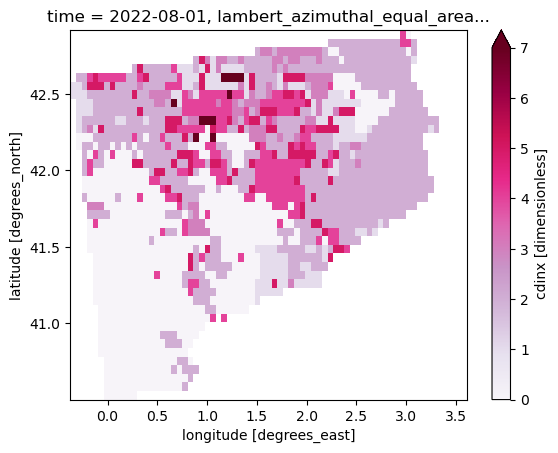

In [16]:
catalonia_cdi_latlon.cdinx.plot(cmap=plt.cm.PuRd, extend='max')

For the plot to really help us to determine drought levels and in our climate risk assessement, we have to make a few changes to the map.

### Custom plot

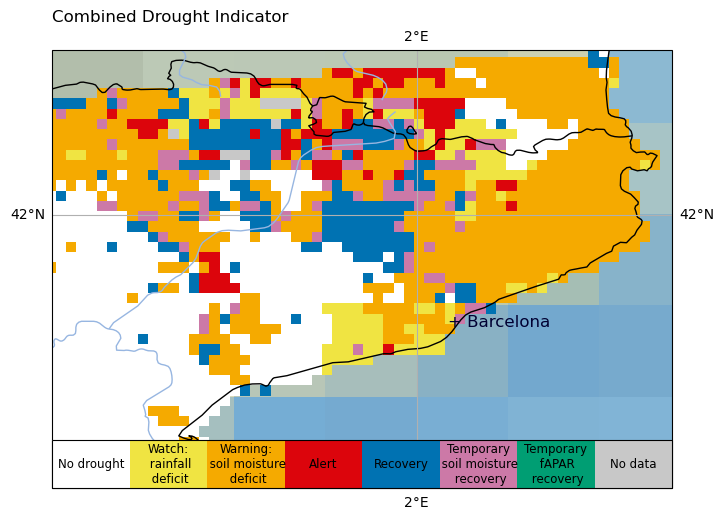

In [17]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Set visible map section
ax.set_extent([xmin, xmax, ymin, ymax], crs=ccrs.PlateCarree())

# Add a land/ocean image in the background
ax.stock_img()

# Plot CDI data
cmap = mpl.colors.ListedColormap(["#ffffff", "#f0e442", "#f5aa00", "#dc050c","#0072b2","#cc79a7","#009e73", "#c8c8c8"])
c = catalonia_cdi_latlon.cdinx.plot(ax=ax, cmap=cmap, vmin=-0.5, vmax=7.5, add_colorbar=False, add_labels=False)

# Customize gridlines
gridlines = c.axes.gridlines(draw_labels=True, dms=False, xlocs=[0, 2, 4], ylocs=[40, 42])
# Add map features
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.RIVERS)

ax.set_title('Combined Drought Indicator', loc = "left")

# Create the categorical colorbar for the CDI data
cax_c = fig.add_axes([
    ax.get_position().x0,
    ax.get_position().y0,
    ax.get_position().width,
    0.08
])
cbar_c = fig.colorbar(c, orientation="horizontal", cax=cax_c)
cbar_c.ax.get_xaxis().set_ticks([])
labels = [
    'No drought',
    'Watch:\n rainfall\n deficit',
    'Warning:\n soil moisture\n deficit',
    'Alert','Recovery',
    'Temporary\n soil moisture\n recovery',
    'Temporary\n fAPAR\n recovery',
    'No data'
]
for j, label in enumerate(labels):
    cbar_c.ax.text(j, .5, label, ha='center', va='center', size=8.5)

# Add a marker and label at the location of Barcelona
barcelona_lon, barcelona_lat = 2.1686, 41.3874
c.axes.text(
    barcelona_lon,
    barcelona_lat,
    '+ Barcelona',
    horizontalalignment='left',
    fontsize=12,
    color='#000032',
    transform=ccrs.PlateCarree()
);

## Conclusions

In this workflow, we have seen how to explore, process and visualise the drought data.

## Contributors
Milana Vuckovic, ECMWF  
Maurizio Mazzoleni, Vrije Universiteit Amsterdam

## Appendix I - Customised plot explained step by step

We will: 
- Add coastlines, rivers and country borders using cartopy
- Set distinct colour levels for CDI
- Remove the default colorbar and labels
- Add custom colorbars and title
- Add custom gridlines
- And finally add a label for Barcelona

### Background 
First we make a basic plot and set geographical extent to our domain. This way we can zoom in without having to manipulate the data.  
We can also add some (low resolution) background.

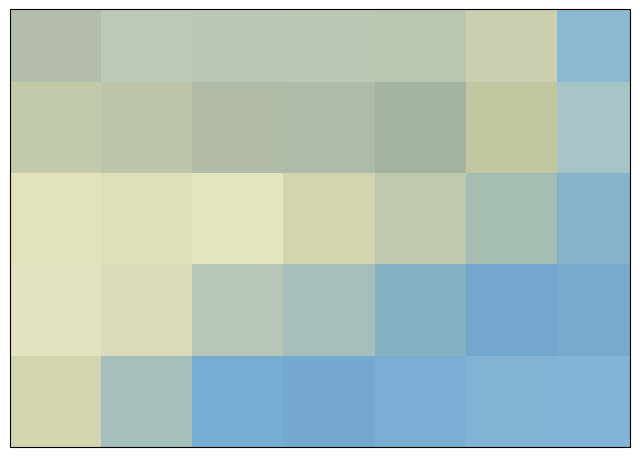

In [18]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Set visible map section
ax.set_extent([xmin, xmax, ymin, ymax], crs=ccrs.PlateCarree())

# Add a land/ocean image in the background
ax.stock_img()

### Adding the data
Next we add the data. We customize the levels on both plots. We will also remove the default colorbar and labels, so that we can add our own in the next step.

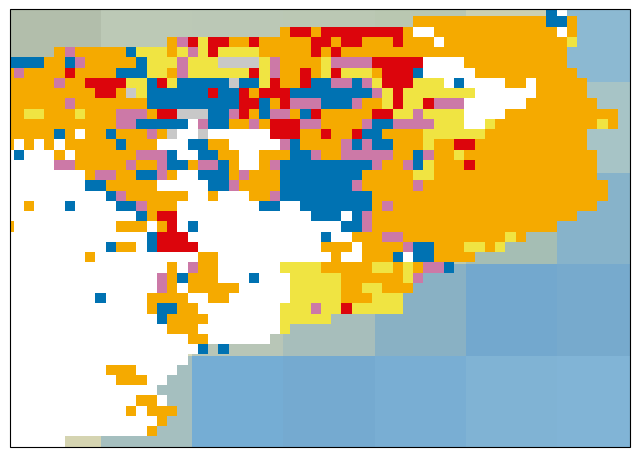

In [19]:
# Plot CDI data
cmap = mpl.colors.ListedColormap(["#ffffff", "#f0e442", "#f5aa00", "#dc050c","#0072b2","#cc79a7","#009e73", "#c8c8c8"])
c = catalonia_cdi_latlon.cdinx.plot(ax=ax, cmap=cmap, vmin=-0.5, vmax=7.5, add_colorbar=False, add_labels=False)

fig # show the updated figure in the notebook

### Adding the geographical features
Next we add the gridlines, coastlines, rivers and country borders.

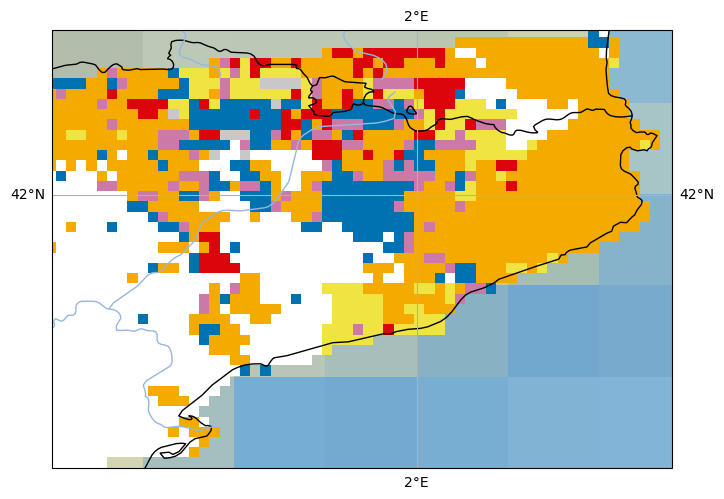

In [20]:
# Customize gridlines
gridlines = c.axes.gridlines(draw_labels=True, dms=False, xlocs=[0, 2, 4], ylocs=[40, 42])
# Add map features
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.RIVERS)

fig # show the updated figure in the notebook

### Adding the title
Then we add the title. 

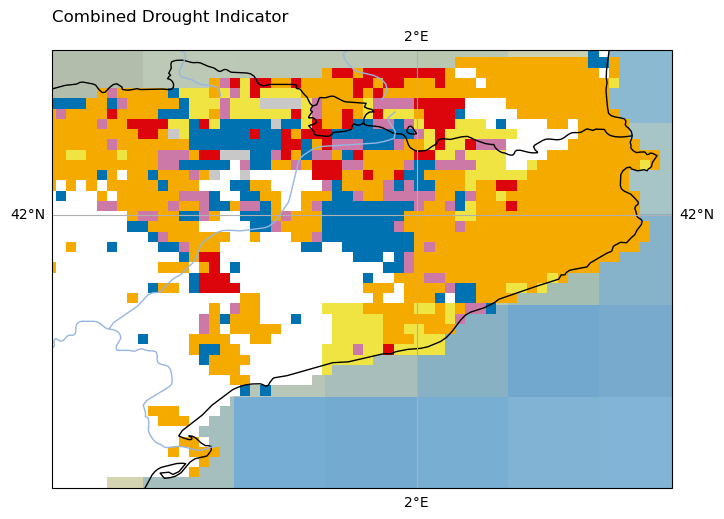

In [21]:
ax.set_title('Combined Drought Indicator', loc = "left")

fig # show the updated figure in the notebook

### Adding the colorbar
It is a little bit tricky to add colorbars to where we want them.  
**cax_p** and **cax_c** variable define the positions and size of the colorbars. They get the default position and size of the colorbars and make them half as long and next to each other.  
In the end we also make the tick labels smaller.

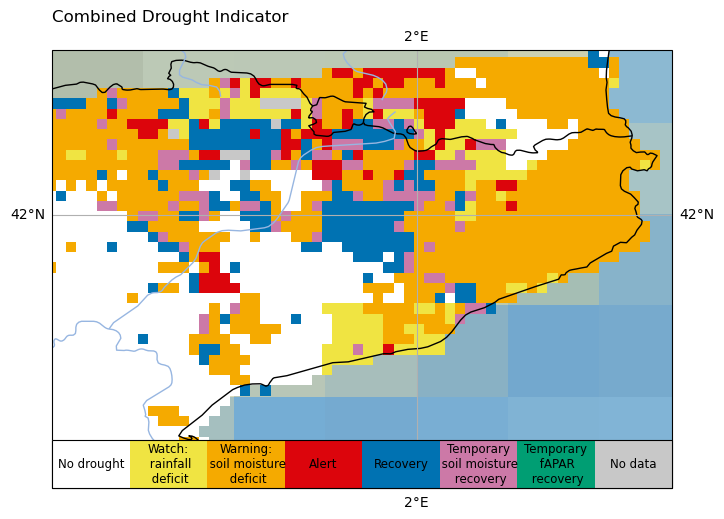

In [22]:
# Create the categorical colorbar for the CDI data
cax_c = fig.add_axes([
    ax.get_position().x0,
    ax.get_position().y0,
    ax.get_position().width,
    0.08
])
cbar_c = fig.colorbar(c, orientation="horizontal", cax=cax_c)
cbar_c.ax.get_xaxis().set_ticks([])
labels = [
    'No drought',
    'Watch:\n rainfall\n deficit',
    'Warning:\n soil moisture\n deficit',
    'Alert','Recovery',
    'Temporary\n soil moisture\n recovery',
    'Temporary\n fAPAR\n recovery',
    'No data'
]
for j, label in enumerate(labels):
    cbar_c.ax.text(j, .5, label, ha='center', va='center', size=8.5)

fig # show the updated figure in the notebook

### Adding the custom text label

Finally we can add the label for Barcelona.

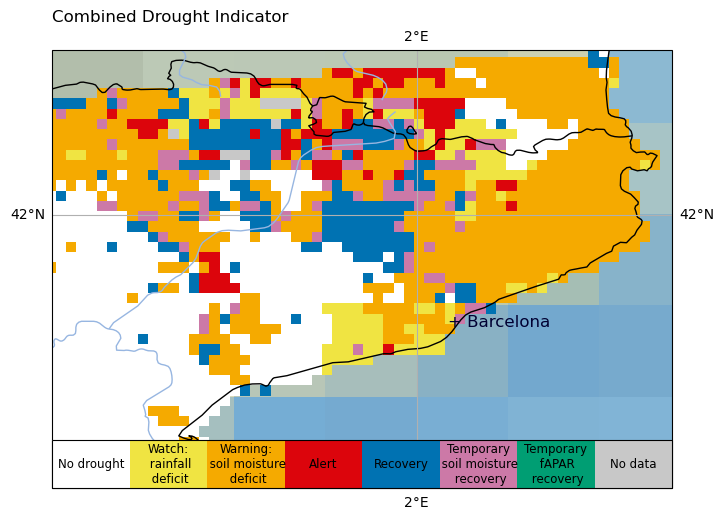

In [23]:
# Add a marker and label at the location of Barcelona
barcelona_lon, barcelona_lat = 2.1686, 41.3874
c.axes.text(
    barcelona_lon,
    barcelona_lat,
    '+ Barcelona',
    horizontalalignment='left',
    fontsize=12,
    color='#000032',
    transform=ccrs.PlateCarree()
)

fig # show the updated figure in the notebook